In [1]:
import json
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tqdm import tqdm
import random
import numpy as np

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
merchant_id = '11167ECFF94860EA'

In [4]:
file = '/data/predict/'+merchant_id+'/'+merchant_id+'_logs.json'

In [5]:
users = {}
with open(file, encoding='utf8') as f:
    for line in tqdm(f):
        data = json.loads(line)
        if data['visitor_id'] not in users:
            users[data['visitor_id']] = []
        for prod_idx in data['viewed_products']:
            try:
                users[data['visitor_id']].append(prod_idx)
            except ValueError: 
                print('Sktrain_labelsiped ' + prod_idx)

59810it [00:00, 127822.48it/s]


In [6]:
users_lens = list(map(lambda x: len(x), users.values()))

In [7]:
print(len(users.keys()))

15710


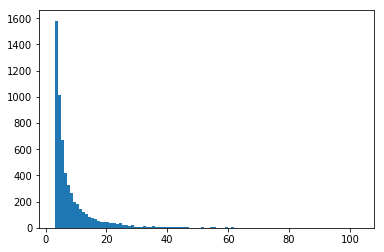

In [8]:
d = plt.hist(users_lens, bins=100, range=(3, 103))

In [9]:
products = {}
for u in users.values():
    for pid in u:
        products[pid] = 1
product_idxs = products.keys()
product_ids = {v: k for k, v in enumerate(product_idxs)}
number_of_classes = len(product_idxs)

In [10]:
print(number_of_classes)

2043


In [11]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [12]:
def dedup(seq):
    seen = set()
    seen_add = seen.add

    return [x for x in seq if not (x in seen or seen_add(x))]


users_with_product_idxs = {}
for uid,products in users.items():
    ids = dedup(list(map(lambda x: product_ids[x], products)))[-40:]
    if len(ids) > 1:
        if len(ids) not in users_with_product_idxs:
            users_with_product_idxs[len(ids)] = []
        users_with_product_idxs[len(ids)].append(ids)
    
del users

In [13]:
max_batch_size = 32
test_size = 0.1
user_batches = []
user_valid_batches = []
for len_group in users_with_product_idxs.values():
    random.shuffle(len_group)
    for batch in chunks(len_group, max_batch_size):
        batch_data = np.array(list(map(lambda x: x[:-1], batch)))
        batch_labels = np.expand_dims(np.array(list(map(lambda x: x[1:], batch))), axis=2)
        if random.random() < test_size:
            user_valid_batches.append(
                (batch_data, batch_labels)
            )
        else:
            user_batches.append(
                (batch_data, batch_labels)
            )

In [14]:

def generate_from_array(arr):
    while True:
        random.shuffle(arr)
        for i in arr: 
            yield i
    

In [35]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Dropout, TimeDistributed,Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam


n_hidden = 200

model=Sequential([
        Embedding(number_of_classes, n_hidden, batch_input_shape=(None,None)),
        BatchNormalization(),
        GRU(4*n_hidden, input_shape=(None,n_hidden),return_sequences=True),
        Dropout(0.2),
        #GRU(4*n_hidden,return_sequences=True),
        #Dropout(0.2),
        #TimeDistributed(Dense(n_hidden, activation='relu')),
        TimeDistributed(Dense(number_of_classes, activation='softmax'))
    ])

In [36]:
from keras.backend import reshape, prod, shape, stack
from keras.metrics import sparse_top_k_categorical_accuracy

def flatten_first_n_dimension(x, first_n=2):
    new_dims = stack([prod(shape(x)[:first_n]), prod(shape(x)[first_n:])])

    return reshape(x, new_dims)

def sparse_timedistributed_top_k_categorical_accuracy(y_true, y_pred, k=5):
    y_true_reshaped = flatten_first_n_dimension(y_true)
    y_pred_reshaped = flatten_first_n_dimension(y_pred)

    return sparse_top_k_categorical_accuracy(y_true_reshaped, y_pred_reshaped, k)

In [37]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy',sparse_timedistributed_top_k_categorical_accuracy], optimizer=Nadam())

In [38]:
import csv
with open('/data/predict/'+merchant_id+'/'+merchant_id+'_variable_length_model_id_map.csv', 'w',encoding='utf8') as csvfile:
    spamwriter = csv.writer(csvfile)
    for line in product_idxs:
        spamwriter.writerow([line])

In [39]:
from keras.callbacks import ModelCheckpoint
filepath='/data/predict/'+merchant_id+'/'+merchant_id+'_variable_length_model-{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_sparse_timedistributed_top_k_categorical_accuracy', verbose=1, save_best_only=False, mode='max')

In [45]:
model.fit_generator(
    generate_from_array(user_batches), 
    validation_data=generate_from_array(user_valid_batches), 
    steps_per_epoch=len(user_batches),
    validation_steps=len(user_valid_batches),
    epochs=1,
    callbacks=[checkpoint]
)

Epoch 1/1
236/236 [==============================] - 3s 13ms/step - loss: 4.5853 - sparse_categorical_accuracy: 0.1536 - sparse_timedistributed_top_k_categorical_accuracy: 0.4004 - val_loss: 5.5530 - val_sparse_categorical_accuracy: 0.0959 - val_sparse_timedistributed_top_k_categorical_accuracy: 0.2735


## Eye ball validation

In [41]:
import csv

In [46]:
product_map = {}
with open('/data/predict/'+merchant_id+'/'+merchant_id+'_catalog.csv', 'r', encoding='utf8') as csvfile:
    spamreader = csv.reader(csvfile)
    header = next(spamreader)
    item_id = header.index('item')
    image_url = header.index('image')
    title = header.index('title')
    link = header.index('link')
    
    for row in spamreader:
        product_map[row[item_id]] = [row[image_url], row[title], row[link]]

In [47]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [51]:
from IPython.core.display import display as core_display
from IPython.core.display import HTML 

def product_to_url(product):
    try:
        
        return [product] + product_map[list(product_idxs)[product]] + [list(product_idxs)[product]]
    except KeyError:
        return [product,'http://www.lackuna.com/wp-content/themes/fearless/images/missing-image-640x360.png','UNKNOWN','', '']

def display_session(session):
    products = list(map(product_to_url, session))
    predictions = model.predict([session])
    html = '<table>'
    seen = set()
    for i,product in enumerate(products):
        html += '<tr>'
        html += '<th style="text-align:center;width:120px">'
        html += '<img src="' + product[1] + '" width="130"><br/>' 
        html += '<a href="'+str(product[3])+'">' + str(product[4]) + '</a></br>' + str(product[2])
        html += '</th><td style="background-color:black;"></td>'
        top_idx = list(np.argsort(predictions[i][0])[::-1])
        seen.add(product[0])
        
        j = 0
        for pred in top_idx:
            if pred in seen:
                continue
                                
            if i < len(products) - 1 and pred == products[i+1][0]:
                style = 'style="border:3px dashed red;"'
            else:
                style = ''
                
            pred_data = product_to_url(pred)
            html += '<td style="width:130px"><img src="' + pred_data[1] + '" '+style+' width="130"><br/>' 
            html += '<a href="'+str(pred_data[3]) + '">' +str(pred_data[4]) + '</a></br>' + str(pred_data[2]) + '</td>'
            j+=1
            if j > 5:
                break
                
        html += '</tr>'
    html += '</table>'

    core_display(HTML(html))

display_session(random.choice(random.choice(user_valid_batches)[0]))

UNKNOWN,,UNKNOWN,UNKNOWN,UNKNOWN,2043560Damen-Daunenjacke mit Kontrast-Futter,UNKNOWN,UNKNOWN
UNKNOWN,,UNKNOWN,UNKNOWN,"2042423Mitteldecke mit winterlicher Stickerei, ca. 80x80cm",UNKNOWN,"2040989Memo-Board aus Holz, mit 9 Clips, ca. 28x50cm",2041500Damen-Pullover mit tollem Strickmuster
UNKNOWN,,UNKNOWN,2043559Damen-2-in-1-Allwetterjacke,2042455Damen-Strickjacke mit Lurexfaden,2040959Damen-Steppjacke mit abgerundetem Saum,2039690Damen-Steppjacke mit Kapuze,UNKNOWN
UNKNOWN,,2043559Damen-2-in-1-Allwetterjacke,2043560Damen-Daunenjacke mit Kontrast-Futter,2041500Damen-Pullover mit tollem Strickmuster,2042442Damen-Pullover mit Chiffon-Einsatz am Saum,2040960Damen-Parka mit Kunstfell,2043309Damen-Carmenshirt mit trendigem Muster
2042551Damen-Strickjacke mit großem Leo-Muster,,2040960Damen-Parka mit Kunstfell,2043659Damen-Jacquardpullover aus flauschigem Material,2043560Damen-Daunenjacke mit Kontrast-Futter,2040373Damen-Steppjacke mit 2-Wege-Reißverschluss,2043299Damen-Shirt mit Leoparden-Muster,2043298Damen-Shirt mit Leo-Muster und Spitze
2041504Damen-Pullover mit trendigen Seitenschlitzen,,2041503Damen-Pullover mit modischem Strickmuster,2043659Damen-Jacquardpullover aus flauschigem Material,2043559Damen-2-in-1-Allwetterjacke,2041507Damen-Pullover in gestrickter Melange-Optik,UNKNOWN,UNKNOWN
2041500Damen-Pullover mit tollem Strickmuster,,2043560Damen-Daunenjacke mit Kontrast-Futter,2043559Damen-2-in-1-Allwetterjacke,2041507Damen-Pullover in gestrickter Melange-Optik,2041503Damen-Pullover mit modischem Strickmuster,2040373Damen-Steppjacke mit 2-Wege-Reißverschluss,2042848Damen-Sweatshirt in trendiger Melange-Optik
2043659Damen-Jacquardpullover aus flauschigem Material,,UNKNOWN,2043299Damen-Shirt mit Leoparden-Muster,UNKNOWN,UNKNOWN,UNKNOWN,2042808Damen-Velvethose in Samt-Optik
2043315Damen-Spitzenshirt mit 2 Volants,,2043287Damen-Rock in Stufen-Optik,2043298Damen-Shirt mit Leo-Muster und Spitze,2043310Damen-Carmenshirt mit elastischem Saum,2042886Damen-Shirt mit Kontrast-Ärmeln,2048126Damen-Leggings mit Vorderseite in PU-Optik,2041481Damen-Chenille-Pullover mit Rollkragen
2042849Damen-Sweatshirt mit Bindebändern,,2042220Damen-Shirt mit dekorativem Ausschnitt,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,2043309Damen-Carmenshirt mit trendigem Muster,2041974Damen-Pullover mit doppellagigem Design,2043559Damen-2-in-1-Allwetterjacke,2043018Damen-Kleid mit modernem Blumenmuster
2045417Damen-Pullover mit Schmucksteinchen,,2040960Damen-Parka mit Kunstfell,2040203Damen-Jacke mit Kunstpelz-Kragen,2043560Damen-Daunenjacke mit Kontrast-Futter,2042704Damen-Pullover mit wunderschöner Rüschenverzierung,2040373Damen-Steppjacke mit 2-Wege-Reißverschluss,2043298Damen-Shirt mit Leo-Muster und Spitze


In [52]:
display_session(np.array([product_ids['2041197']]))

"2041197Damen-Strickjacke im offenen Cardigan-Stil, große Größen",,"2040854Damen-Jacke im Parka-Stil, große Größen","2039251Damen-Strickjacke mit kreativem Streifenmuster, große Größen",2040373Damen-Steppjacke mit 2-Wege-Reißverschluss,2043559Damen-2-in-1-Allwetterjacke,2041972Damen-Strickjacke mit großen Knöpfen,"2040893Damen-Jacke mit trendigem Leo-Muster, große Größen"


In [50]:
grouped_by_last_item = {}
for batch in user_valid_batches:
    for session in batch[0]:
        if session[-1] not in grouped_by_last_item:
            grouped_by_last_item[session[-1]] = []
        grouped_by_last_item[session[-1]].append(session)


In [ ]:
gr = random.choice(grouped_by_last_item)
s1 = random.choice(gr)
s2 = random.choice(gr)
display_session(s1)
display_session(s2)